# **Libraries**

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import pandas
import sklearn
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,Conv2DTranspose,Concatenate,UpSampling2D,Add,Input,BatchNormalization,Embedding,Reshape,UpSampling2D,Activation
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import plot_model

# **Data**

In [7]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sprites/sprites_1788_16x16.npy
/kaggle/input/sprites/sprite_labels_nc_1788_16x16.npy


# **Load & Visualize**

In [2]:
sprites=np.load("D:\INeuron\sprites\sprites_1788_16x16.npy\sprites_1788_16x16.npy")
labels=np.load("D:\INeuron\sprites\sprite_labels_nc_1788_16x16.npy\sprite_labels_nc_1788_16x16.npy")

In [3]:
def plotImageData(images,labels):
    
    plt.figure(figsize=(3,3))
    
    for i in range(16):
        
        plt.subplot(4,4,i+1)
        plt.imshow(images[i])
    
    plt.show()

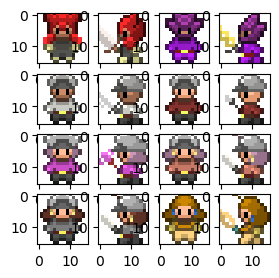

In [8]:
plotImageData(sprites[16:32],labels[16:32])

# **Design Model**

### Layer

In [11]:
class DownSampling2D(Layer):

    def __init__(self, filters,kernel_size,M2DKernel_Size, **kwargs):
        super(DownSampling2D, self).__init__(**kwargs)
        
        self.conv1=Conv2D(filters,kernel_size,activation="relu")
        self.conv2=Conv2D(filters,kernel_size,activation="relu")
        self.conv3=Conv2D(1,(1,1),activation="relu")

    
    def call(self,inp):
        
        x=inp
        x=self.conv1(x)
        x=self.conv2(x)
        y=self.conv3(x)
        
        return x,y

In [15]:
class UpSamplingD(Layer):

    def __init__(self, filters,kernel_size,units,reshape, **kwargs):
        super(UpSamplingD, self).__init__(**kwargs)
        
        self.reshape=reshape
        self.units=units
        
        self.conv1t=Conv2DTranspose(filters,kernel_size,activation="relu")
        self.upsampl=UpSampling2D()
        self.dense1=Dense(self.units)
        self.dense2=Dense(self.units)
    

    
    def call(self,inp):
        
        prev,embed,skip=inp
        y=Flatten()(embed)
        z=Flatten()(skip)
        x=self.conv1t(prev)
        x=self.upsampl(prev)
        x=Flatten()(x)
        x=Flatten()(Concatenate()([x,y]))
        
        k=Flatten()(Concatenate()([x,z]))
        
        l=Activation("relu")(Concatenate()([x,k]))

        
        x=self.dense1(l)
        x=self.dense2(x)
        x=tf.keras.layers.Reshape(self.reshape)(x)

        return x

In [13]:
class FeatureGate(Layer):

    def __init__(self,**kwargs):
        super(FeatureGate, self).__init__(**kwargs)
        
        self.dense1=Dense(5000,activation="relu")
        self.dense2=Dense(5000,activation="relu")
        self.dense4=Dense(5000,activation="relu")
        self.dense3=Dense(8*8*32,activation="relu")
        self.dense5=Dense(1024,activation="relu")
        self.my_variable = self.add_weight(
            name="my_variable",
            shape=(1,),
            initializer="zeros",
            trainable=True,
        )
    


    def  call(self,X):
        
        imgIp,emb=X
        
        emb=Flatten()(emb)
        
        dense1=self.dense5(emb)  
        
        y=Flatten()(imgIp)
        
        y=self.dense1(y)
        y=self.dense2(y)
        y=self.dense2(y)

 
        x=Concatenate()([dense1,y])
        y=self.dense3(x)
   
        y=tf.keras.layers.Reshape((8,8,32))(y)
        
        return y
        

In [16]:
ip=Input((16,16,3),name="pixel")
ip2=Input((5,),name="label")
x,x_skip1=DownSampling2D(filters=32,kernel_size=(3,3),M2DKernel_Size=(1,1))(ip)
x,x_skip2=DownSampling2D(filters=32,kernel_size=(2,2),M2DKernel_Size=(1,1))(x)
x,x_skip3=DownSampling2D(filters=32,kernel_size=(2,2),M2DKernel_Size=(1,1))(x)

embed=Embedding(5,128)(ip2)
dense1=Dense(256)(embed)

x=FeatureGate()([x,dense1])

x=UpSamplingD(8,(1,1),12*12*16,(12,12,16))([x,dense1,x_skip3])
x=UpSamplingD(8,(1,1),14*14*8,(14,14,8))([x,dense1,x_skip2])
x=UpSamplingD(8,(1,1),16*16*1,(16,16,1))([x,dense1,x_skip1])
op=Conv2D(1,(1,1),activation="relu",name="output")(x)



In [17]:
model=Model(inputs=[ip,ip2],outputs=[op])

In [18]:
model.compile(optimizer="adam",loss="mae")

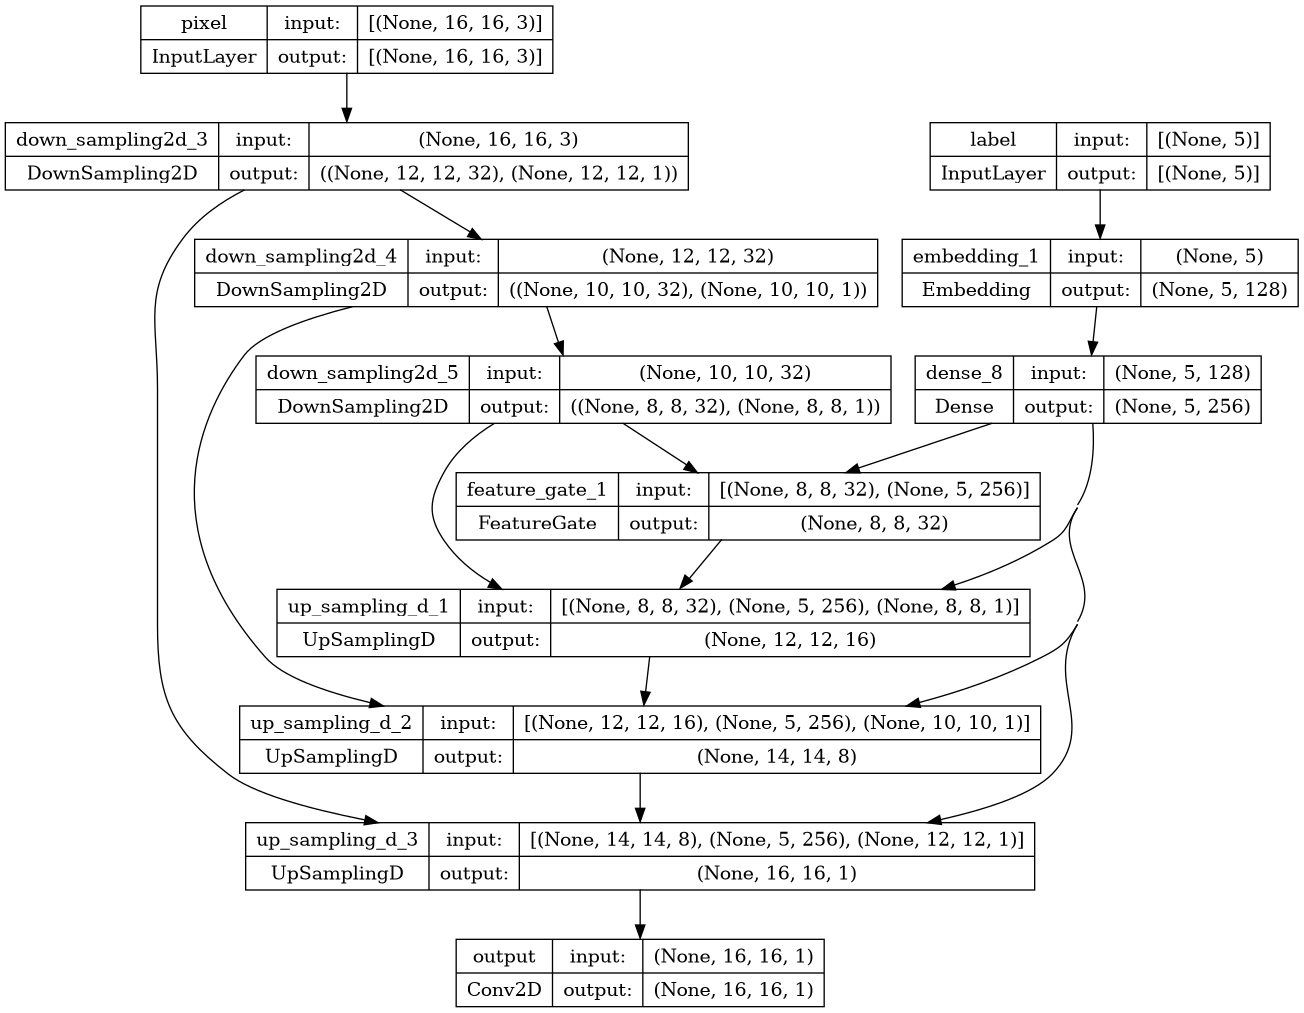

In [19]:
plot_model(model,show_layer_names=True,show_shapes=True)

In [25]:
X={

    "pixel":sprites,
    "label":labels
    
}

Y={
    
    "output":sprites,
    
}

dataset=tf.data.Dataset.from_tensor_slices((X,Y))
dataset = dataset.batch(1)

In [26]:
model.fit(dataset)

 1415/89400 [..............................] - ETA: 47:22 - loss: 232.9043

KeyboardInterrupt: 